This notebook take inspiration from the Nvidia's [SegNet](https://github.com/dusty-nv/pytorch-segmentation/tree/master).

In [1]:
import torchvision
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.transform import resize

from math import floor
from dataclasses import dataclass
from pathlib import Path

from semantic_segmentation.dataset import get_sets as get_semantic_sets
from semantic_segmentation.dataset import InputType
from ipywidgets import interact, BoundedIntText
from utils.dataset import get_dataloader
from params import PROJECT_PATH
from sam_pipeline_utils import compute_semantic_segmentation, CostType
from semantic_segmentation.sam_pipeline_utils import downsample_to_grid
from params.dataset import TOP_UNUSED_ROWS


device = "cuda"

if device == "cuda":
    # Benchmark different convolution algorithms and use the fastest one
    torch.backends.cudnn.benchmark = True

# Config

In [2]:
@dataclass
class SegTrainingConfig:
    dataset_dir: Path = (
        PROJECT_PATH
        / "datasets/Distillation dataset/smaller_dataset_distillation_all"
    )
    weights: "weight" = (
        torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT
    )
    batch_size: int = 64
    num_epochs: int = 100
    lr: float = 1e-3
    lr_max_decay: float = 0.01
    lr_decay_step: int = 50


config = SegTrainingConfig()

In [3]:
%%script false --no-raise-error

# XXX: debug
config = SegTrainingConfig(
    dataset_dir=PROJECT_PATH
    / "datasets/Distillation dataset/fake_dataset_distillation",
)

# Dataset

In [4]:
train_set, val_set, test_set = get_semantic_sets(config.dataset_dir)
train_loader, val_loader, test_loader = get_dataloader(
    train_set, val_set, test_set, batch_size=config.batch_size
)

# Model

In [5]:
torchvision.models.list_models(torchvision.models.segmentation)

['deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'fcn_resnet101',
 'fcn_resnet50',
 'lraspp_mobilenet_v3_large']

In [6]:
def get_model(config):
    model = torchvision.models.segmentation.fcn_resnet50(
        weights=config.weights,
        progress=True,
    )

    # Adapt for our task of traversal semantic segmentation
    model.classifier[-1] = torch.nn.Conv2d(
        512, 1, kernel_size=(1, 1), stride=(1, 1)
    )
    model.aux_classifier[-1] = torch.nn.Conv2d(
        256, 1, kernel_size=(1, 1), stride=(1, 1)
    )

    return model.to(device)

In [7]:
model = get_model(config)

# Training

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, 1, config.lr_max_decay, config.lr_decay_step
)

In [9]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = torch.nn.functional.mse_loss(x, target.unsqueeze(1))

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]


def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = torch.tensor(0.0).to(device)
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss

    avg_train_loss = total_loss.item() / len(train_loader)
    return avg_train_loss


def evaluate(model, val_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_pred_val = model(x_val)["out"]
            val_loss += torch.nn.functional.mse_loss(
                y_pred_val, y_val.unsqueeze(1)
            ).item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

In [10]:
def train_model(
    config, model, train_loader, val_loader, optimizer, lr_scheduler, device
):
    progress_bar = tqdm(range(config.num_epochs), desc="Epoch")
    train_loss_list = []
    val_loss_list = []

    for _ in progress_bar:
        train_loss = train(model, train_loader, optimizer, device)
        val_loss = evaluate(model, val_loader, device)

        lr_scheduler.step()
        progress_bar.set_description(
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch"
        )

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

    return train_loss_list, val_loss_list

In [11]:
%%script false --no-raise-error

train_loss_list, val_loss_list = train_model(
    config, model, train_loader, val_loader, optimizer, lr_scheduler, device
)

In [12]:
%%script false --no-raise-error

evaluate(model, test_loader, device)

In [13]:
%%script false --no-raise-error

torch.save(model.state_dict(), "logs/model_new_size_data_aug.pth")

In [14]:
weights = torch.load("logs/model_new_size_data_aug.pth")
model.load_state_dict(weights)

<All keys matched successfully>

# Results?

Text(0, 0.5, 'Loss')

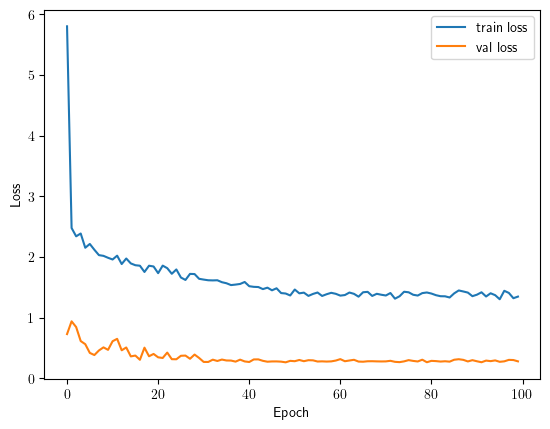

In [15]:
%%script false --no-raise-error

plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [16]:
%%script false --no-raise-error

whole_image_dataset = (
    PROJECT_PATH / "datasets/Distillation dataset/dataset_distillation_all"
)

visualization_set = test_set


@interact(index=BoundedIntText(0, min=0, max=len(visualization_set) - 1))
def visualize_prediction(index):
    model.eval()
    with torch.no_grad():
        image, target = visualization_set[index]
        image = image.unsqueeze(0).to(device)
        output = model(image)["out"]

    _, axes = plt.subplots(1, 5, figsize=(30, 4))

    test_index = visualization_set.indexes[index]
    whole_image_path = config.dataset_dir / f"images/{test_index:05d}.png"
    whole_image = plt.imread(whole_image_path)
    output = output.squeeze().cpu().numpy()
    top_height = (
        floor(output.shape[0] / (1 - TOP_UNUSED_ROWS)) - output.shape[0]
    )
    axes[0].imshow(whole_image)
    axes[0].imshow(whole_image)
    axes[0].axhline(top_height, linestyle="dotted", color="red")
    axes[0].axis("off")
    axes[0].set_title("Source Image")

    axes[1].imshow(target.squeeze().numpy(), cmap="hot_r", vmin=2, vmax=6)
    axes[1].set_title("Target (SAM Pipeline)")
    axes[1].axis("off")

    colorbar = axes[2].imshow(output, cmap="hot_r", vmin=2, vmax=6)
    axes[2].set_title("Predicted Result (distillation)")
    axes[2].axis("off")

    plt.colorbar(colorbar, ax=axes, shrink=0.5, location="bottom")

    whole_target = np.load(
        whole_image_dataset / f"targets/{test_index:05d}.npy"
    )

    top_half = np.zeros((top_height, output.shape[1]))
    whole_output = np.vstack((top_half, output))

    whole_output = resize(
        whole_output,
        whole_target.shape,
        mode="reflect",
        anti_aliasing=True,
    )
    axes[3].imshow(whole_target)

    costmap_target = downsample_to_grid(whole_target)
    costmap_output = downsample_to_grid(whole_output)

    axes[3].imshow(costmap_target, cmap="hot_r", vmin=2, vmax=6)
    axes[3].set_title("Target Costmap\n(i.e. SAM Pipeline)")
    axes[3].axis("off")
    axes[4].imshow(costmap_output, cmap="hot_r", vmin=2, vmax=6)
    axes[4].set_title("Predicted Costmap\n(i.e. distillation)")
    axes[4].axis("off")

## Artefacts of bilinear upsampling

In [17]:
import inspect

print(inspect.getsource(model.forward))

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        input_shape = x.shape[-2:]
        # contract: features is a dict of tensors
        features = self.backbone(x)

        result = OrderedDict()
        x = features["out"]
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode="bilinear", align_corners=False)
        result["out"] = x

        if self.aux_classifier is not None:
            x = features["aux"]
            x = self.aux_classifier(x)
            x = F.interpolate(x, size=input_shape, mode="bilinear", align_corners=False)
            result["aux"] = x

        return result



In [18]:
img, _ = train_set[0]

In [19]:
features = model.backbone(img.unsqueeze(0).to(device))

x = features["out"]
x = model.classifier(x)

x_interp = torch.nn.functional.interpolate(
    x, size=img.shape[-2:], mode="bilinear", align_corners=False
)

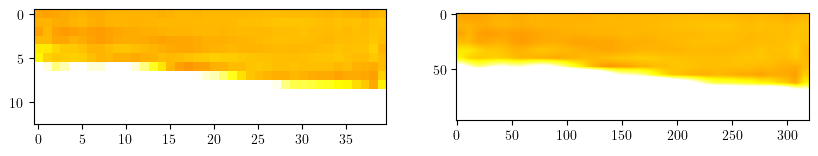

In [20]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(x.squeeze().cpu().detach().numpy(), cmap="hot_r", vmin=2, vmax=6)
ax2.imshow(
    x_interp.squeeze().cpu().detach().numpy(), cmap="hot_r", vmin=2, vmax=6
)

# Benchmarking models

## Distilled model

In [21]:
from timeit import timeit

model.eval()
benchmark_image, _ = test_set[0]
benchmark_image = benchmark_image.unsqueeze(0).to(device)

In [22]:
%%script false --no-raise-error
%%timeit

with torch.no_grad():
    model(benchmark_image)

## Full SAM pipeline

In [23]:
def get_image(img_path: Path) -> np.array:
    with Image.open(img_path) as pil_img:
        pil_img = pil_img.resize((180, 320))
        return np.array(pil_img)


img = get_image(config.dataset_dir / "images" / "00000.png")
depth = get_image(config.dataset_dir / "images" / "00000d.png")
normal = get_image(config.dataset_dir / "images" / "00000n.png")

In [24]:
%%script false --no-raise-error
%%timeit

with torch.no_grad():
    compute_semantic_segmentation(
        img,
        depth,
        normal,
        should_fill_segmentation=True,
        cost_type=CostType.CENTERED,
        should_filter_intersection=True,
        completeness_threshold=0,
    )

## Plot

Text(0.5, 1.0, 'Comparison of SAM_pipeline and distilled_pipeline')

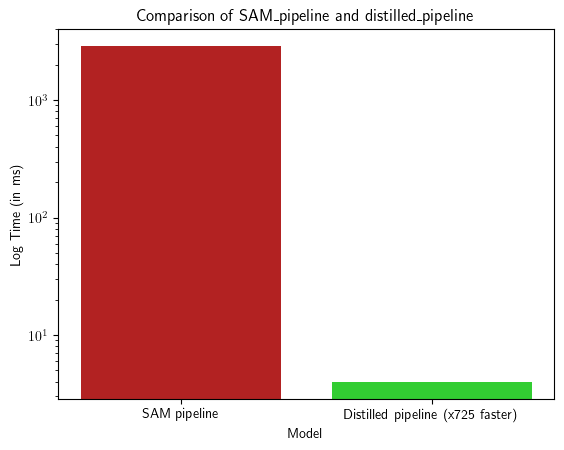

In [25]:
# %%script false --no-raise-error

# XXX: time written below are computed with the 2 above %%timeit
sam_pipeline_time = 2900
distilled_pipeline_time = 4

values = [sam_pipeline_time, distilled_pipeline_time]
labels = [
    "SAM pipeline",
    f"Distilled pipeline (x{sam_pipeline_time // distilled_pipeline_time} faster)",
]

plt.bar(labels, values, color=["firebrick", "limegreen"])
plt.xlabel("Model")
plt.ylabel("Log Time (in ms)")
plt.yscale("log")
plt.title("Comparison of SAM_pipeline and distilled_pipeline")

# Profiling Training
we need to fasten the training process in order to perform Hyperparameters tuning on it.

In [26]:
from torch.profiler import profile, ProfilerActivity, record_function

In [27]:
%%script false --no-raise-error

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True,
    with_stack=True,
) as prof:
    train(model, train_loader, optimizer, device)

In [28]:
%%script false --no-raise-error

prof.export_chrome_trace("trace_non_blocking.json")

# Hyperparameters tuning

In [29]:
from torchvision import transforms
from ray import train as ray_train
from ray import tune
from ray.tune.search.optuna import OptunaSearch

from semantic_segmentation.dataset import (
    DEFAULT_SEG_GEOMETRIC_AUGMENTATION_TRANSFORM,
)
from utils.dataset import DEFAULT_IMAGE_AUGMENTATION_TRANSFORM
from utils.hp_tuning import (
    get_multiple_choice,
    get_multiple_choice_seach_space,
    plot_trials_multiple_choice,
)

In [30]:
image_augmentation_search_space = get_multiple_choice_seach_space(
    "image_augmentation", DEFAULT_IMAGE_AUGMENTATION_TRANSFORM.transforms
)
geometric_augmentation_search_space = get_multiple_choice_seach_space(
    "geometric_augmentation",
    DEFAULT_SEG_GEOMETRIC_AUGMENTATION_TRANSFORM.transforms,
)

In [31]:
search_space = {
    **image_augmentation_search_space,
    **geometric_augmentation_search_space,
}


def get_loaders_from_config(config, hp_config):
    image_augmentation_transforms = get_multiple_choice(
        hp_config,
        "image_augmentation",
        DEFAULT_IMAGE_AUGMENTATION_TRANSFORM.transforms,
    )
    geometric_augmentation_transforms = get_multiple_choice(
        hp_config,
        "geometric_augmentation",
        DEFAULT_SEG_GEOMETRIC_AUGMENTATION_TRANSFORM.transforms,
    )

    image_augmentation_transforms = transforms.Compose(
        image_augmentation_transforms
    )
    geometric_augmentation_transforms = transforms.Compose(
        geometric_augmentation_transforms
    )

    train_set, val_set, test_set = get_semantic_sets(
        config.dataset_dir,
        image_augmentation_transform=image_augmentation_transforms,
        geometric_augmentation_transform=geometric_augmentation_transforms,
    )
    return get_dataloader(
        train_set, val_set, test_set, batch_size=config.batch_size
    )


def trial(hp_config):
    config = SegTrainingConfig()

    train_loader, val_loader, test_loader = get_loaders_from_config(
        config, hp_config
    )
    model = get_model(config)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, 1, config.lr_max_decay, config.lr_decay_step
    )

    train_model(
        config,
        model,
        train_loader,
        val_loader,
        optimizer,
        lr_scheduler,
        device,
    )
    return evaluate(model, test_loader, device)

In [32]:
gpu_trial = tune.with_resources(trial, {"cpu": 12, "gpu": 1})

In [33]:
%%script false --no-raise-error

algo = OptunaSearch()

tuner = tune.Tuner(
    gpu_trial,
    tune_config=tune.TuneConfig(
        mode="min",
        search_alg=algo,
        num_samples=100,
    ),
    param_space=search_space,
)
results = tuner.fit()

In [34]:
%%script false --no-raise-error

results.experiment_path

In [35]:
results = tune.Tuner.restore(
    # "/home/g_thomas/ray_results/siamese_hp_tuning_data_aug/",
    "/home/g_thomas/ray_results/trial_2023-12-19_10-00-41",
    trainable=gpu_trial,
).get_results()

2023-12-21 11:42:46,402	WARNING experiment_analysis.py:185 -- Failed to fetch metrics for 1 trial(s):
- trial_95b979eb: FileNotFoundError('Could not fetch metrics for trial_95b979eb: both result.json and progress.csv were not found at /home/g_thomas/ray_results/trial_2023-12-19_10-00-41/trial_95b979eb_95_geometric_augmentation_0=False,geometric_augmentation_1=False,geometric_augmentation_2=True,geometric_augmentati_2023-12-21_11-18-09')


In [36]:
df = results.get_dataframe()
df

,_metric,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,config/image_augmentation_0,config/image_augmentation_1,config/image_augmentation_2,config/image_augmentation_3,config/image_augmentation_4,config/geometric_augmentation_0,config/geometric_augmentation_1,config/geometric_augmentation_2,config/geometric_augmentation_3,logdir
0,0.231394,1702978337,None,False,1,e004fe47,2023-12-19_10-32-17,1887.159580,1887.159580,12763,...,False,False,False,True,True,True,True,True,False,e004fe47
1,0.172935,1702980311,None,False,1,e9fd4845,2023-12-19_11-05-11,1973.880884,1973.880884,12763,...,False,False,True,True,False,False,False,False,False,e9fd4845
2,0.196466,1702982300,None,False,1,9bd97c24,2023-12-19_11-38-20,1989.106441,1989.106441,12763,...,True,True,False,False,False,False,False,False,True,9bd97c24
3,0.258116,1702984254,None,False,1,e7aad824,2023-12-19_12-10-54,1954.334540,1954.334540,12763,...,True,False,False,False,True,True,True,False,True,e7aad824
4,0.237159,1702986216,None,False,1,a353330f,2023-12-19_12-43-36,1961.866830,1961.866830,12763,...,True,True,False,True,False,False,True,False,True,a353330f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.163457,1703146274,None,False,1,49d8215d,2023-12-21_09-11-14,1871.336775,1871.336775,12763,...,False,False,False,False,False,False,False,True,False,49d8215d
89,0.157340,1703148157,None,False,1,d704af5a,2023-12-21_09-42-37,1882.491143,1882.491143,12763,...,False,False,False,False,False,False,False,True,False,d704af5a
90,0.156289,1703150028,None,False,1,3bd1864b,2023-12-21_10-13-48,1871.145649,1871.145649,12763,...,False,False,False,False,False,False,False,True,False,3bd1864b
91,0.164550,1703151995,None,False,1,3547f87b,2023-12-21_10-46-35,1966.739721,1966.739721,12763,...,False,True,False,False,False,False,False,True,False,3547f87b


In [37]:
best = df.iloc[df["_metric"].argmin()]

results.get_best_result().config, results.get_best_result()

({'image_augmentation_0': False,
  'image_augmentation_1': False,
  'image_augmentation_2': False,
  'image_augmentation_3': False,
  'image_augmentation_4': False,
  'geometric_augmentation_0': False,
  'geometric_augmentation_1': False,
  'geometric_augmentation_2': True,
  'geometric_augmentation_3': False},
 Result(
   metrics={'_metric': 0.15265197645534168},
   path='/home/g_thomas/ray_results/trial_2023-12-19_10-00-41/trial_86ec7650_86_geometric_augmentation_0=False,geometric_augmentation_1=False,geometric_augmentation_2=True,geometric_augmentati_2023-12-21_06-33-48',
   filesystem='local',
   checkpoint=None
 ))

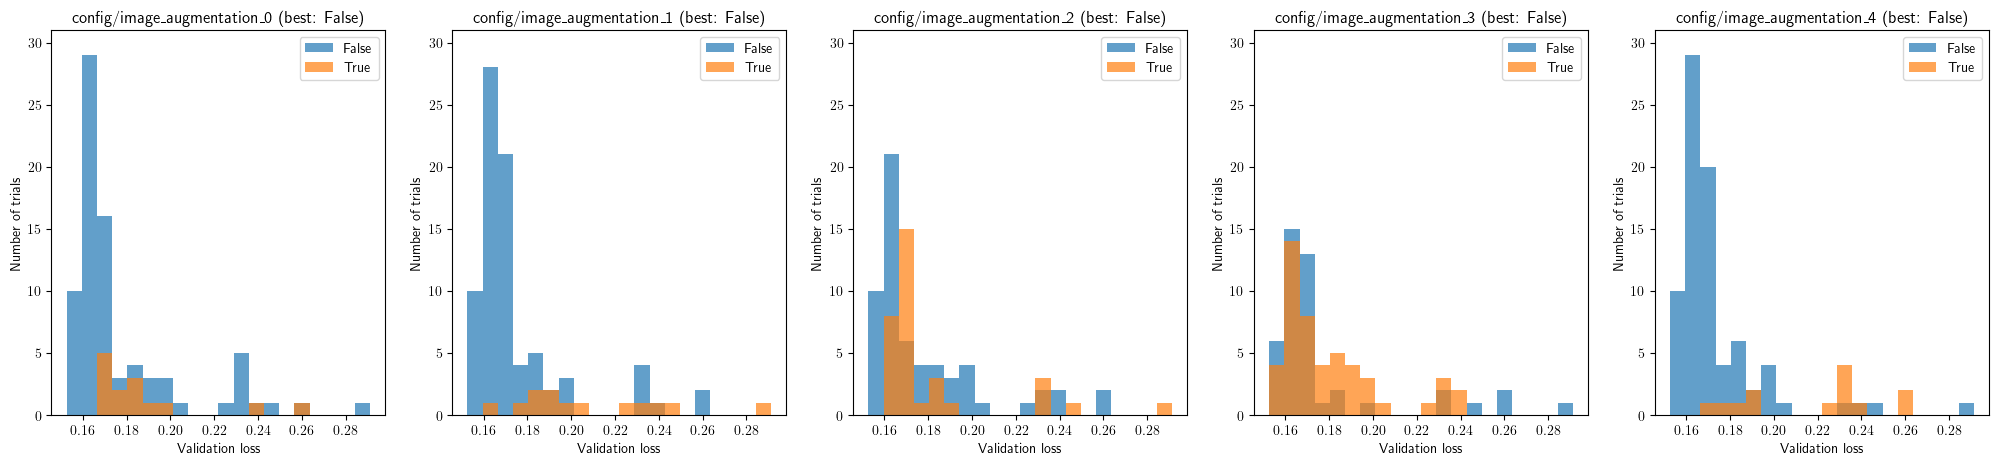

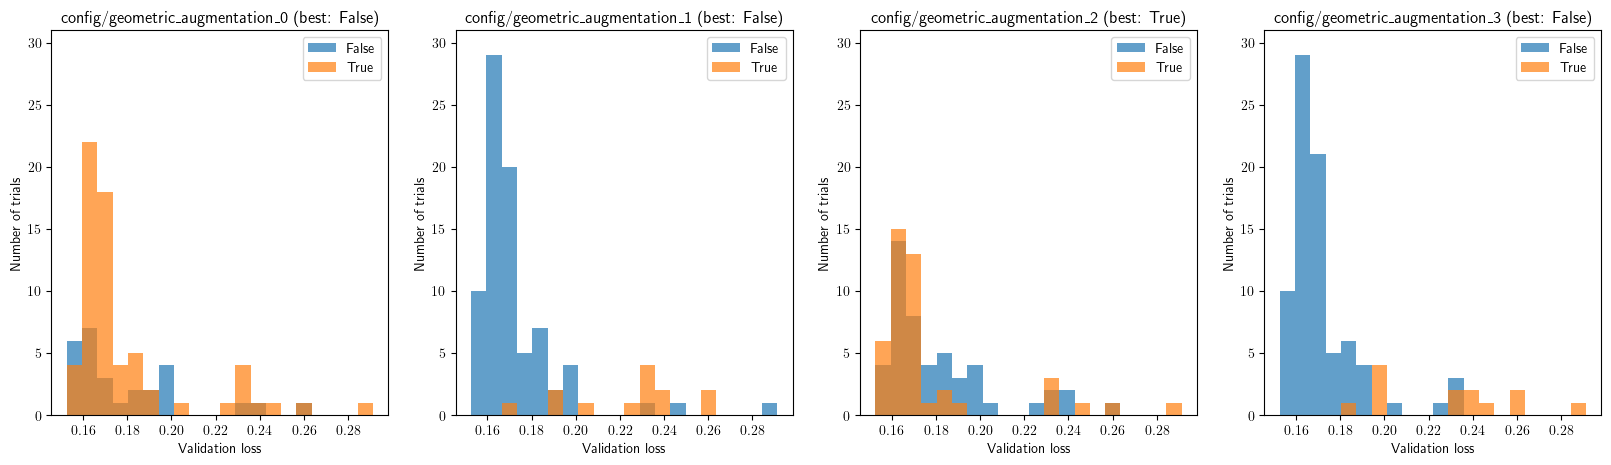

In [38]:
plot_trials_multiple_choice(df, "config/image_augmentation", "_metric")
plot_trials_multiple_choice(df, "config/geometric_augmentation", "_metric")